In [259]:
import pickle
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rl.fuzzing_action import FuzzingAction

In [260]:
smart_folder_name = "2023-06-13T23:33:.647945"

smart_interesting_folder = Path(f"../corpus/interesting/{smart_folder_name}")

smart_folder = Path(f"../data/{smart_folder_name}")
baseline_folder = Path("../data/2023-06-13T21:18:.106542_baseline")

smart_files = list(smart_folder.rglob("*.pkl"))
baseline_files = list(baseline_folder.rglob("*.pkl"))

step_re = r"run_data_(\d+).pkl"

smart_latest_step = 0
baseline_latest_step = 0

for file in smart_files :
    step_match = re.match(step_re, file.name)
    step = int(step_match.group(1))
    if step > smart_latest_step:
        smart_latest_step = step

for file in baseline_files :
    step_match = re.match(step_re, file.name)
    step = int(step_match.group(1))
    if step > baseline_latest_step:
        baseline_latest_step = step

latest_step = min(smart_latest_step, baseline_latest_step)

In [261]:
with open(smart_folder / f"run_data_{latest_step}.pkl", "rb") as f:
    smart_run_data = pickle.load(f)

with open(baseline_folder / f"run_data_{latest_step}.pkl", "rb") as f:
    baseline_run_data = pickle.load(f)

smart_episode_actions = smart_run_data["episode_actions"]
smart_episode_rewards = smart_run_data["episode_rewards"]
smart_losses = smart_run_data["losses"]
smart_execution_coverage = smart_run_data["execution_coverage"]
smart_final_coverage = smart_run_data["current_coverage"]
smart_total_steps = smart_run_data["total_steps"]
smart_total_executions = smart_run_data["total_executions"]
smart_failed_actions = smart_run_data["failed_actions"]
smart_running_time = smart_run_data["running_time"]

baseline_episode_actions = baseline_run_data["episode_actions"]
baseline_episode_rewards = baseline_run_data["episode_rewards"]
baseline_execution_coverage = baseline_run_data["execution_coverage"]
baseline_final_coverage = baseline_run_data["current_coverage"]
baseline_total_steps = baseline_run_data["total_steps"]
baseline_total_executions = baseline_run_data["total_executions"]

In [262]:
baseline_episode_rewards_summed = [sum(x) for x in baseline_episode_rewards]
smart_episode_rewards_summed = [sum(x) for x in smart_episode_rewards]

baseline_episode_len = [len(x) for x in baseline_episode_rewards]
smart_episode_len = [len(x) for x in smart_episode_rewards]

print(f"Smart running time: {smart_running_time}")
print(
    f"Average episode reward: {np.mean(smart_episode_rewards_summed)}, {np.mean(baseline_episode_rewards_summed)}"
)
print(
    f"Average episode length: {np.mean(smart_episode_len)}, {np.mean(baseline_episode_len)}"
)

print(
    f"Final coverage: smart: {smart_final_coverage:.5%}, baseline: {baseline_final_coverage:.5%}"
)
print(f"Total steps: smart: {smart_total_steps}, baseline: {baseline_total_steps}")
print(
    f"Total executions: smart: {smart_total_executions}, baseline: {baseline_total_executions}"
)
print(
    f"Number of episodes: smart: {len(smart_episode_rewards)}, baseline: {len(baseline_episode_rewards)}"
)

Smart running time: 1:16:10.800552
Average episode reward: -16.84951821086262, -5.672556503282104
Average episode length: 29.000894568690097, 8.922448016980464
Final coverage: smart: 21.03203%, baseline: 21.12152%
Total steps: smart: 227000, baseline: 227000
Total executions: smart: 41865, baseline: 41522
Number of episodes: smart: 7825, baseline: 25441


Text(0.5, 1.0, 'Coverage vs. Number of Actions')

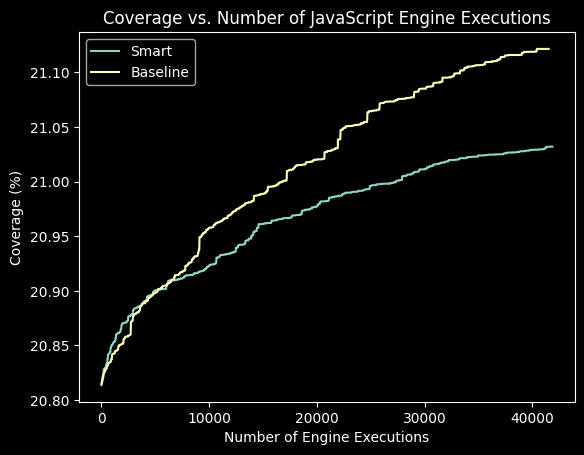

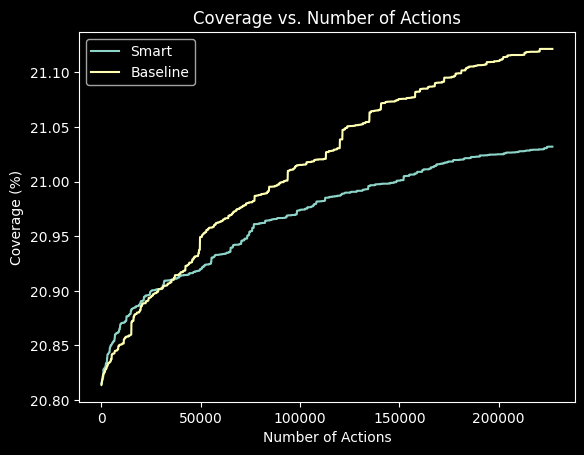

In [263]:
smart_x_exec = []
smart_x_action = []
smart_y = []

baseline_x_exec = []
baseline_x_action = []
baseline_y = []

for (execution, num_actions), coverage in smart_execution_coverage.items():
    smart_x_exec.append(execution)
    smart_x_action.append(num_actions)
    smart_y.append(coverage * 100)

for (execution, num_actions), coverage in baseline_execution_coverage.items():
    baseline_x_exec.append(execution)
    baseline_x_action.append(num_actions)
    baseline_y.append(coverage * 100)

plt.figure()
sns.lineplot(x=smart_x_exec, y=smart_y, label="Smart")
sns.lineplot(x=baseline_x_exec, y=baseline_y, label="Baseline")
plt.xlabel("Number of Engine Executions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of JavaScript Engine Executions")
plt.legend(loc="upper left")

plt.figure()
sns.lineplot(x=smart_x_action, y=smart_y, label="Smart")
sns.lineplot(x=baseline_x_action, y=baseline_y, label="Baseline")
plt.xlabel("Number of Actions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of Actions")

(-40.0, 10.0)

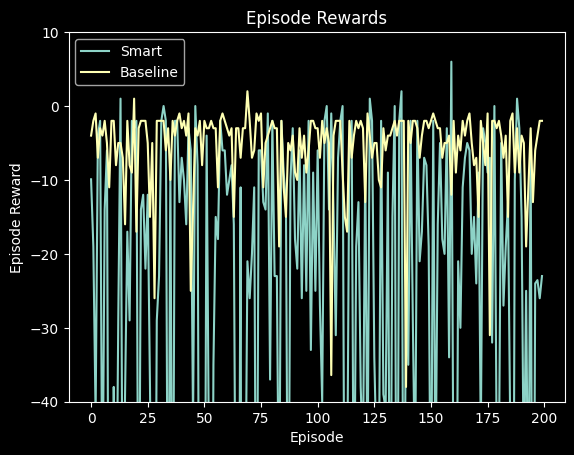

In [264]:
episodes = min(len(smart_episode_rewards), len(baseline_episode_rewards))
window = 200

plt.figure()
sns.lineplot(
    x=np.arange(len(smart_episode_rewards_summed[episodes-window:episodes])),
    y=smart_episode_rewards_summed[episodes-window:episodes],
    label="Smart",
)
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-40, 10)

plt.title("Episode Rewards")

sns.lineplot(
    x=np.arange(len(baseline_episode_rewards_summed[episodes-window:episodes])),
    y=baseline_episode_rewards_summed[episodes-window:episodes],
    label="Baseline",
)
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-40, 10)

Text(0.5, 1.0, 'Loss')

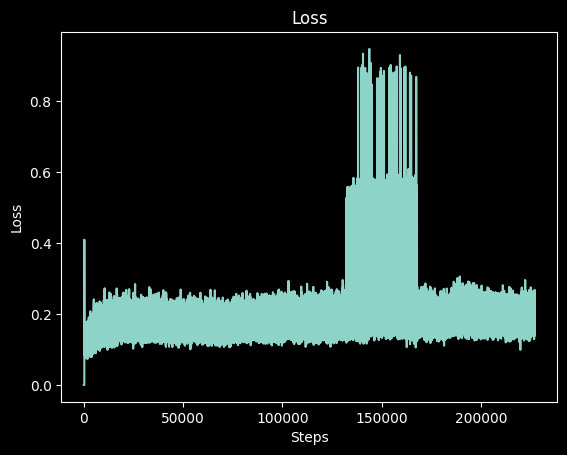

In [265]:
sns.lineplot(x=np.arange(len(smart_losses)), y=smart_losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss")

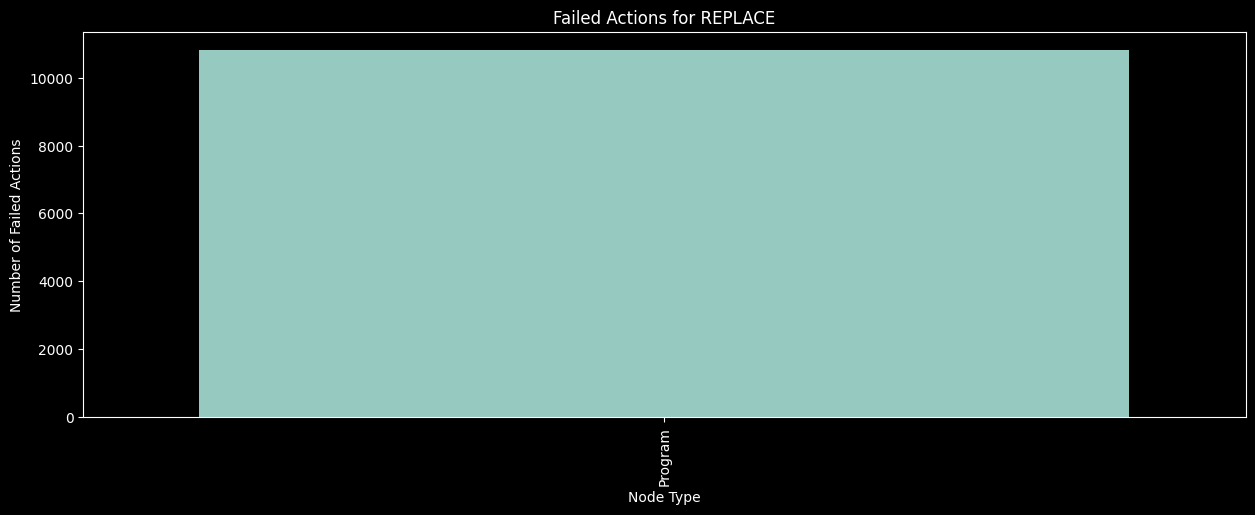

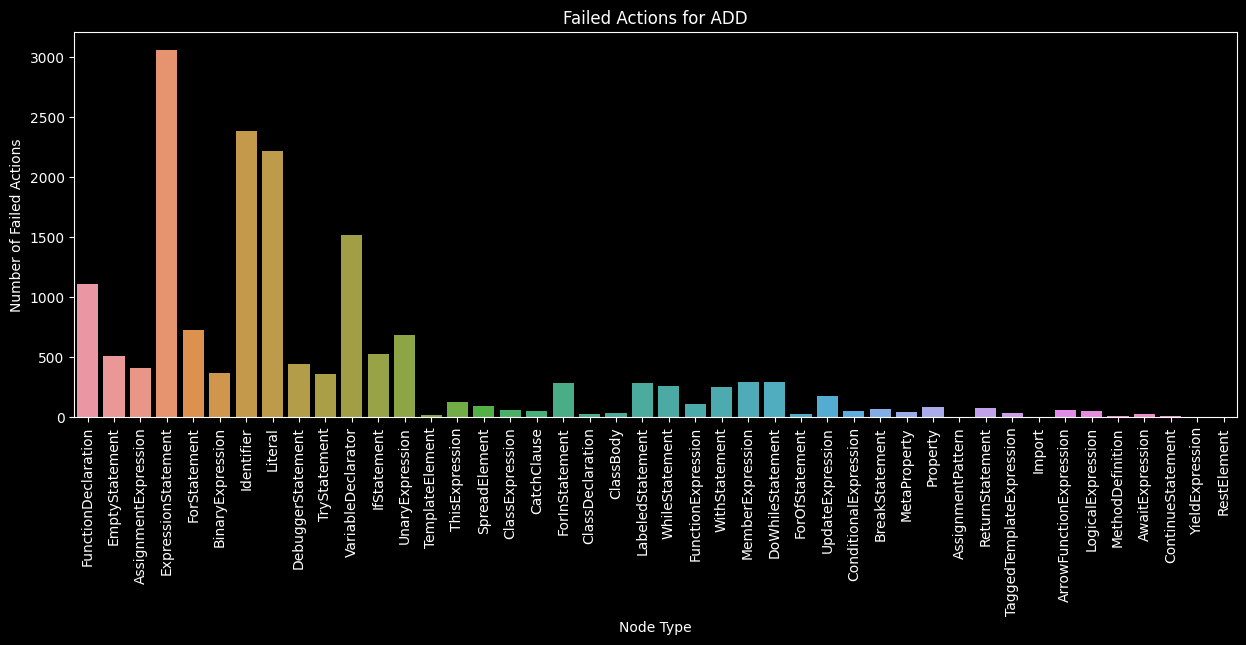

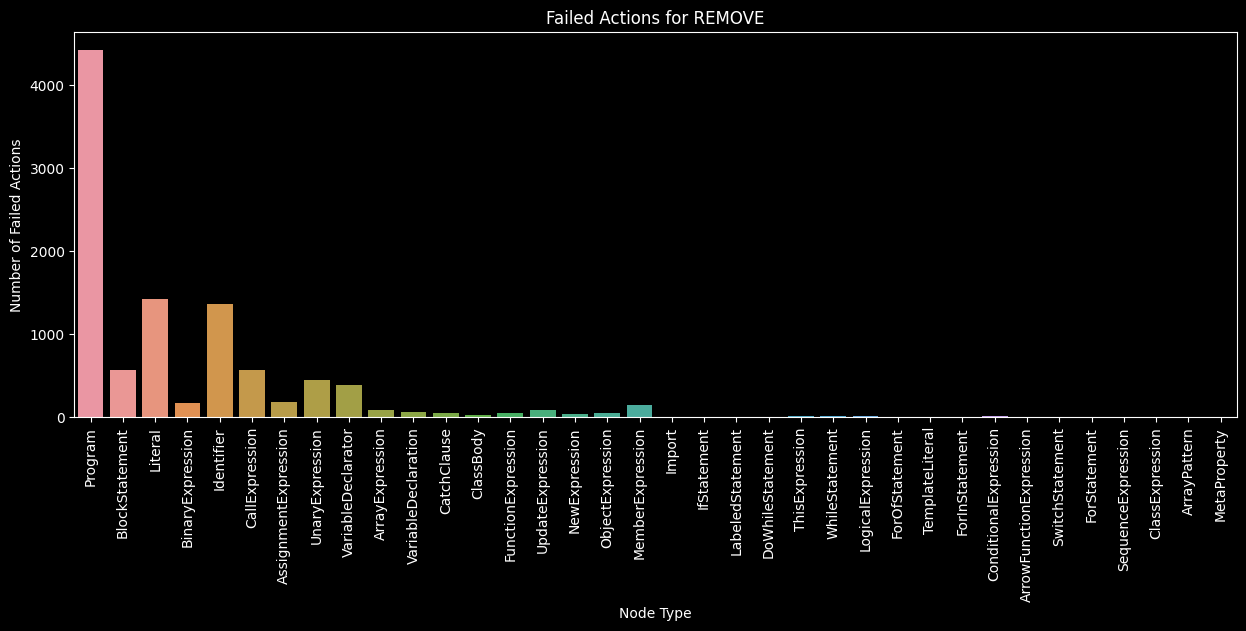

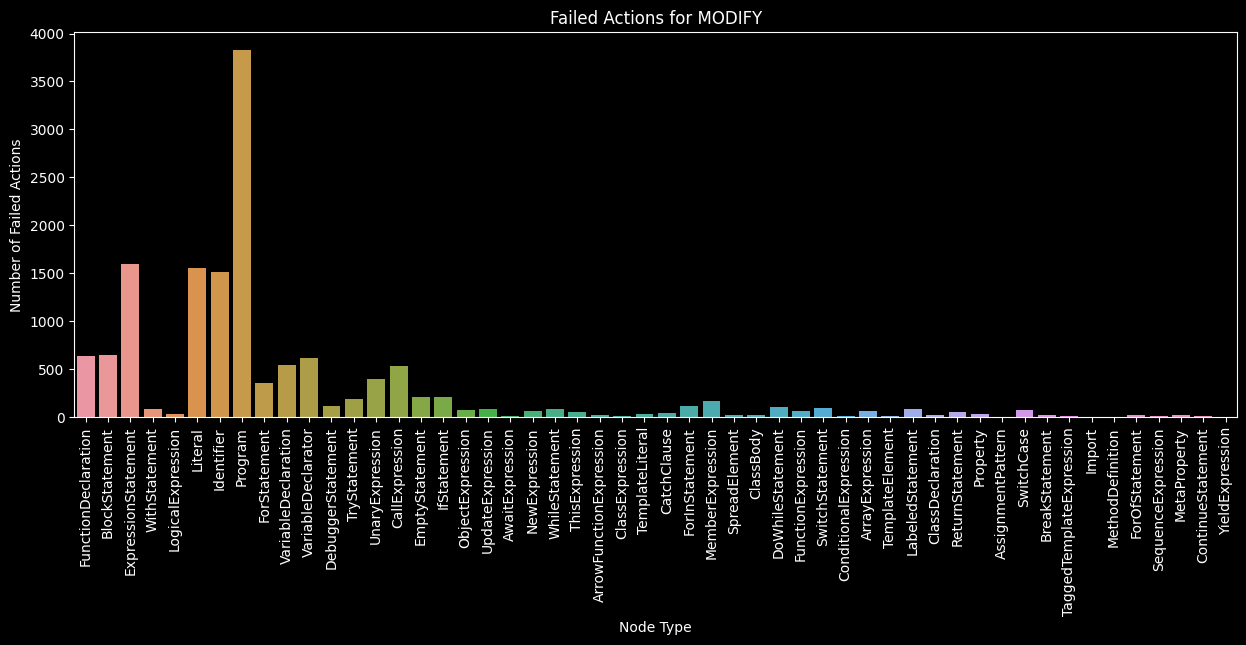

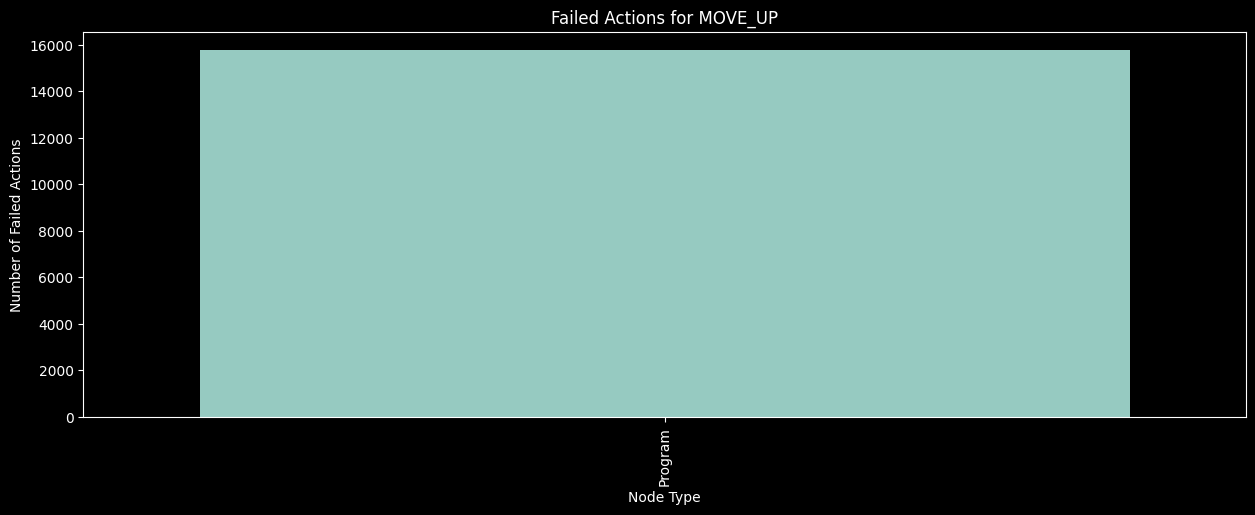

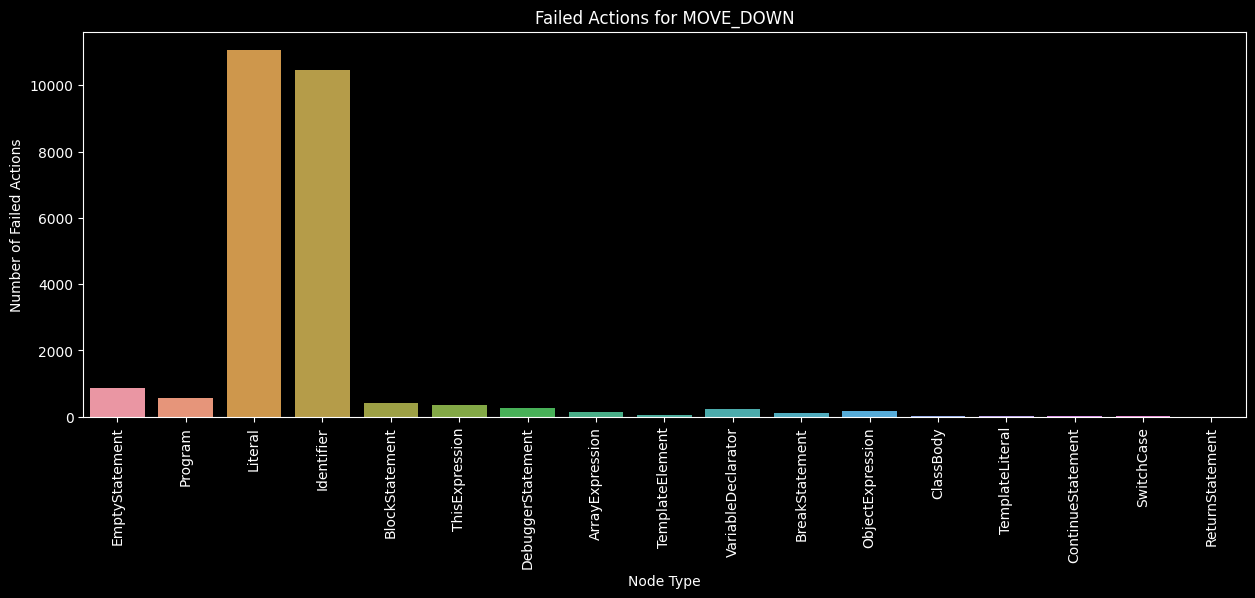

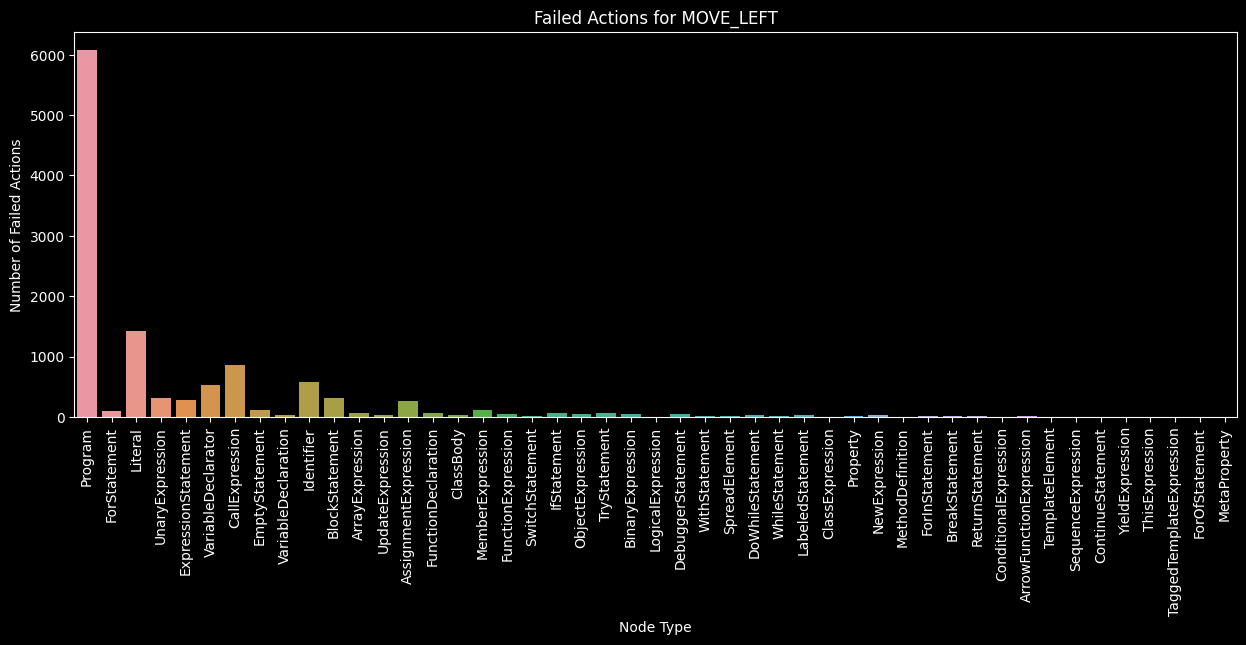

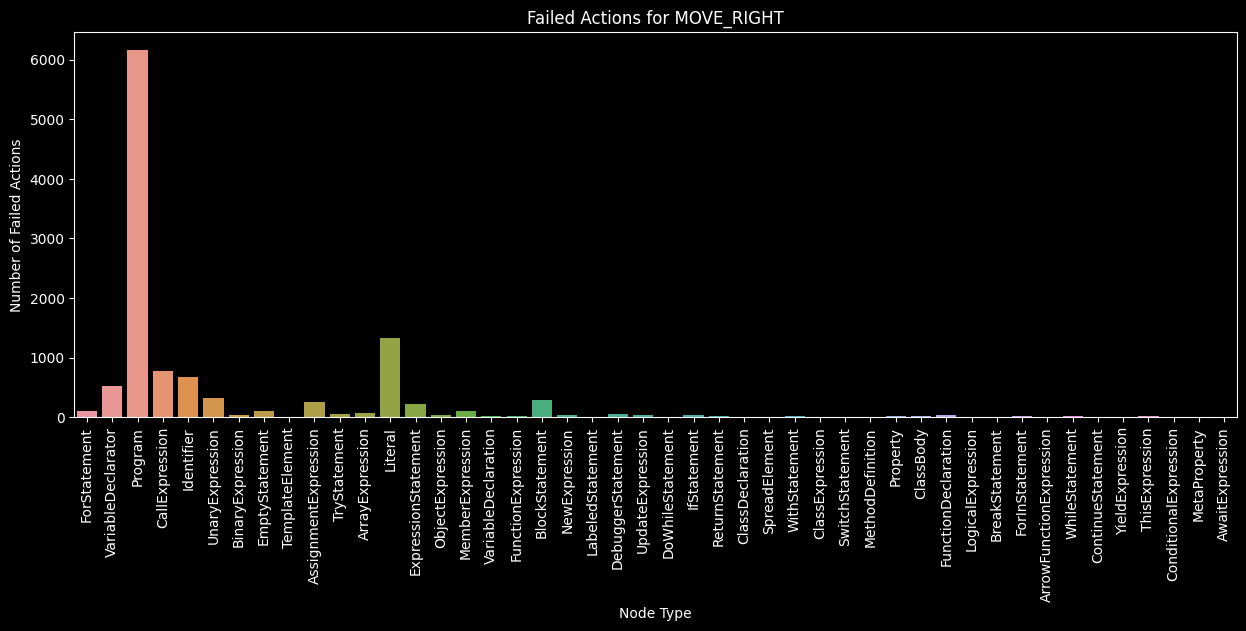

In [266]:
from collections import defaultdict


for action in FuzzingAction:
    filtered_failed_actions = [x[1] for x in smart_failed_actions if x[0] == action]

    if len(filtered_failed_actions) == 0:
        continue

    smart_failed_action_counts = Counter(filtered_failed_actions)
    smart_failed_action_counts = pd.DataFrame(
        smart_failed_action_counts.items(), columns=["node_type", "count"]
    )

    # Plot the distribution of actions by node type using seaborn
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x="node_type", y="count", data=smart_failed_action_counts)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(f"Failed Actions for {action.name}")
    ax.set_xlabel("Node Type")
    ax.set_ylabel("Number of Failed Actions")

In [267]:
smart_episode_actions = [item for sublist in smart_episode_actions for item in sublist]
baseline_episode_actions = [
    item for sublist in baseline_episode_actions for item in sublist
]

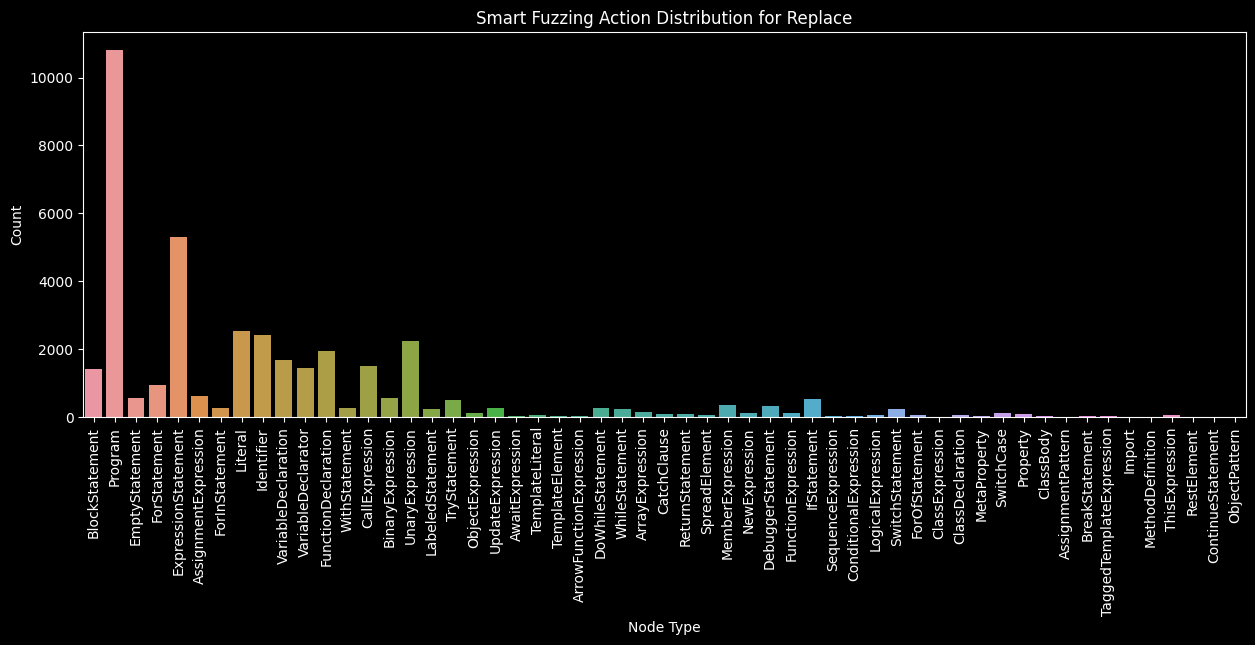

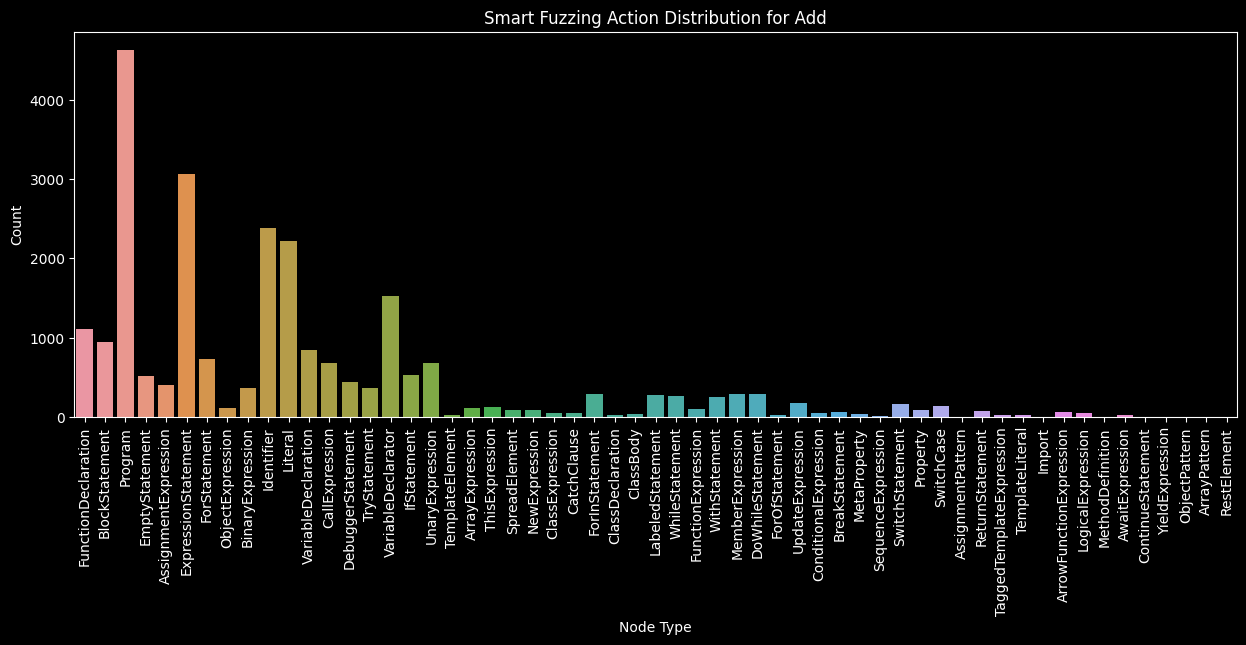

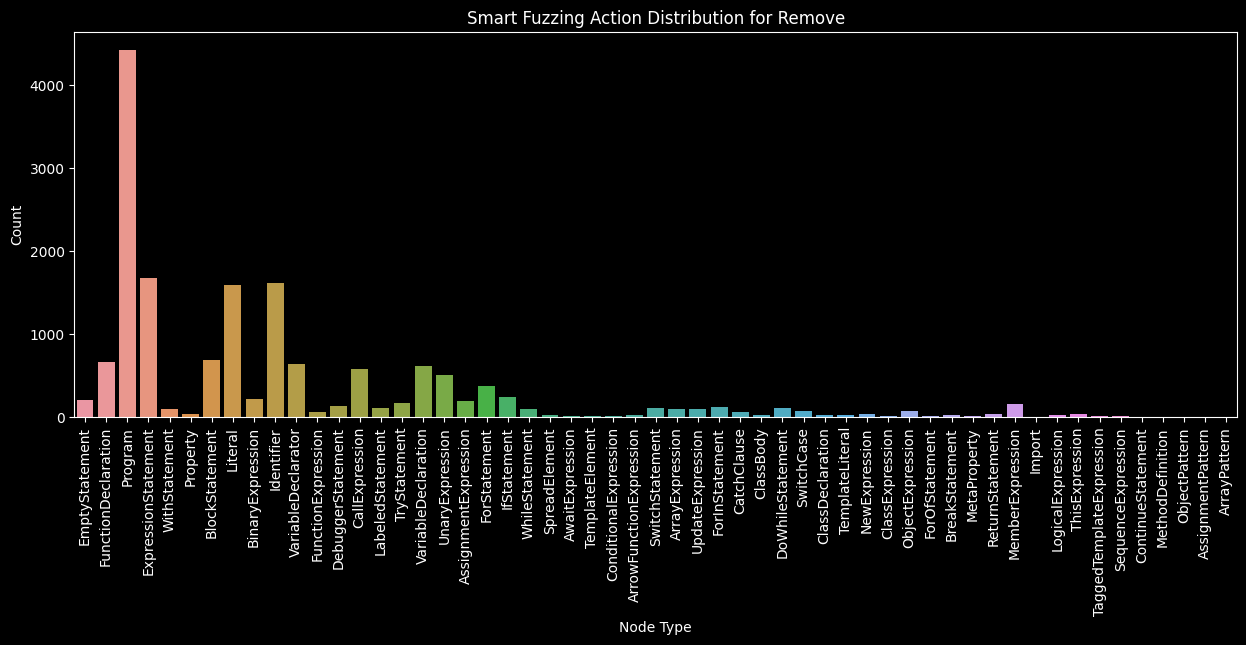

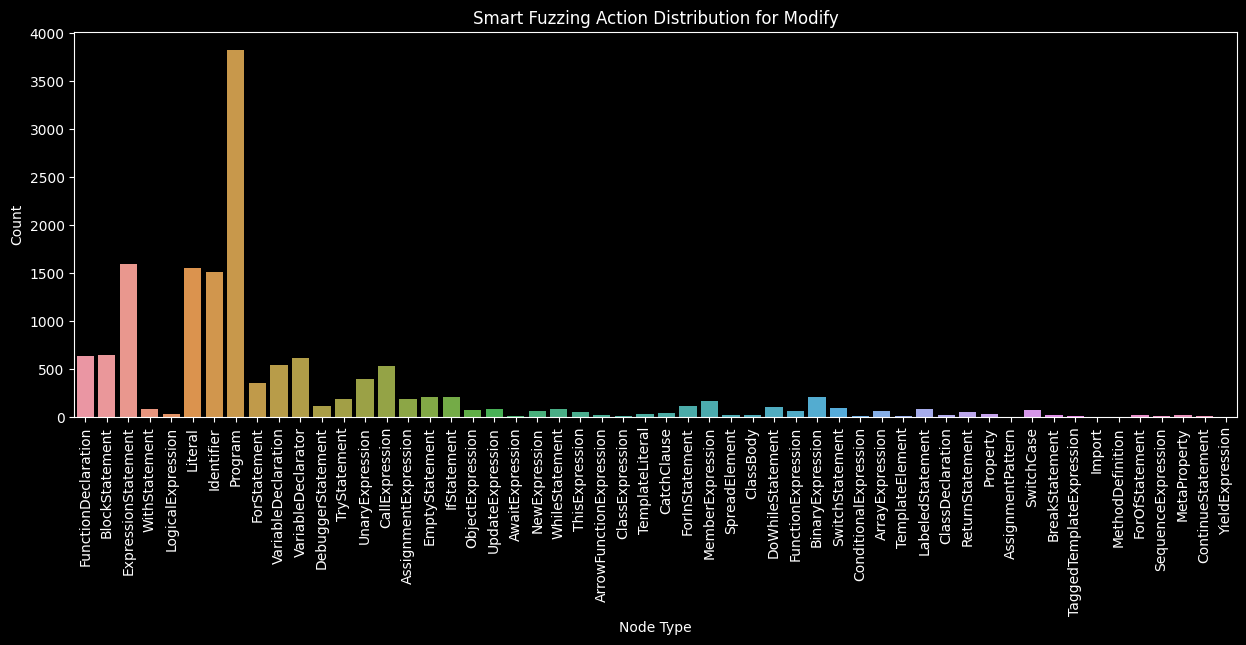

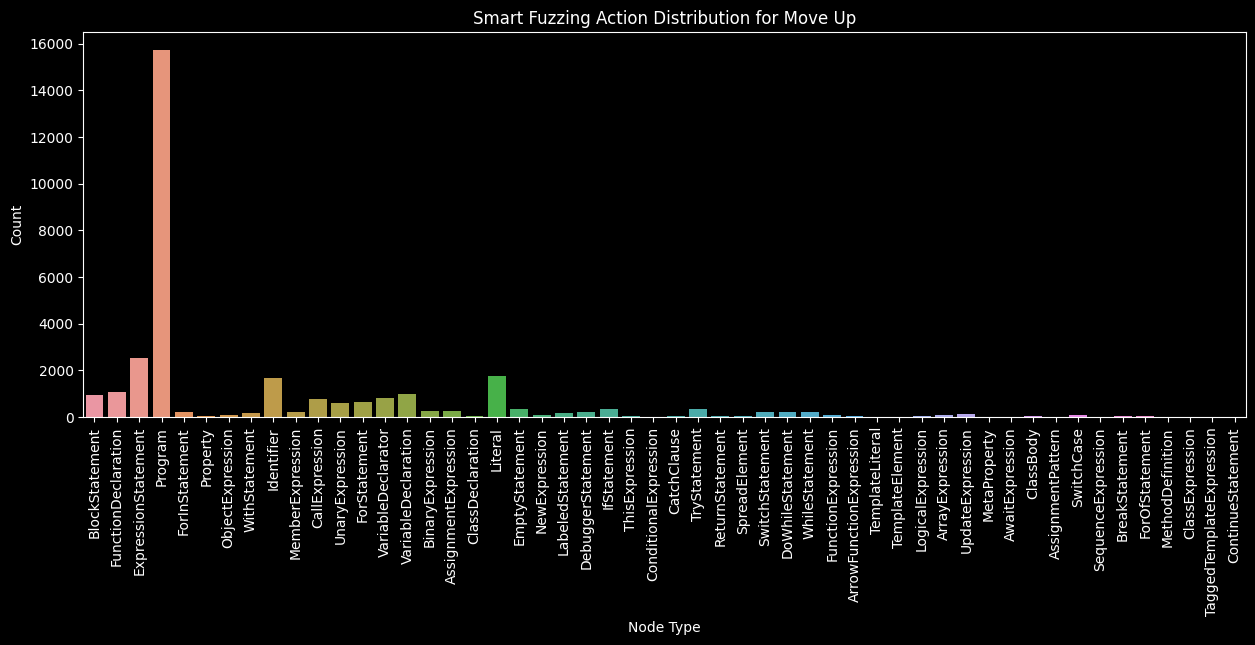

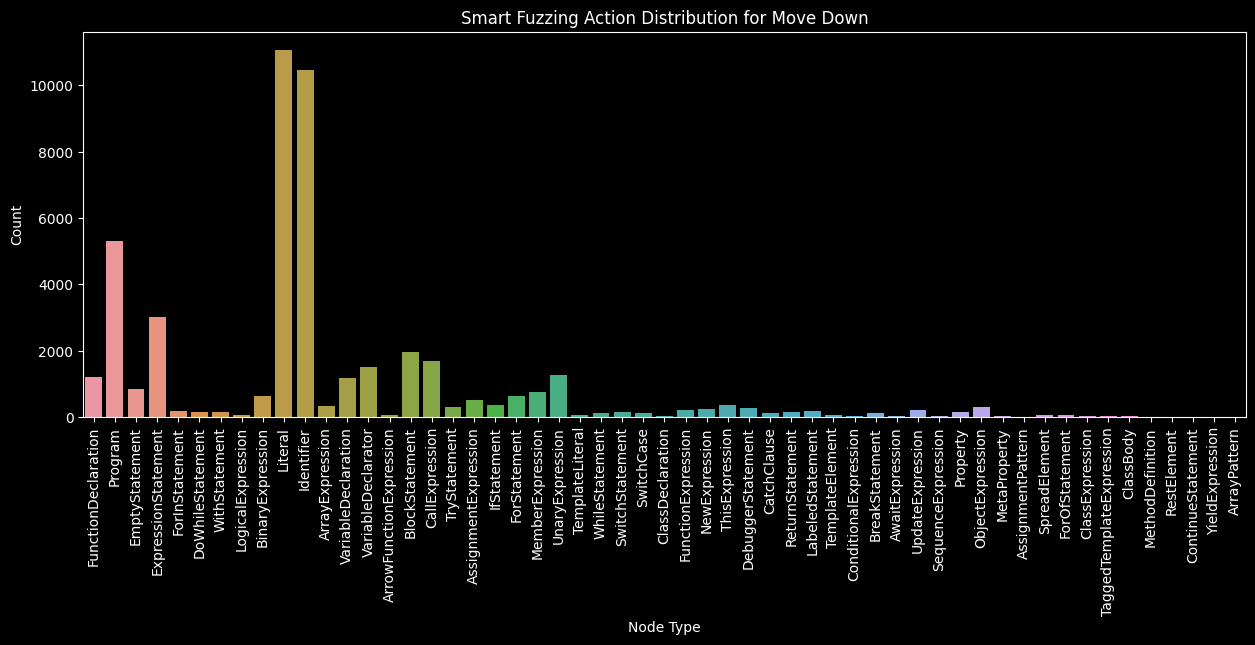

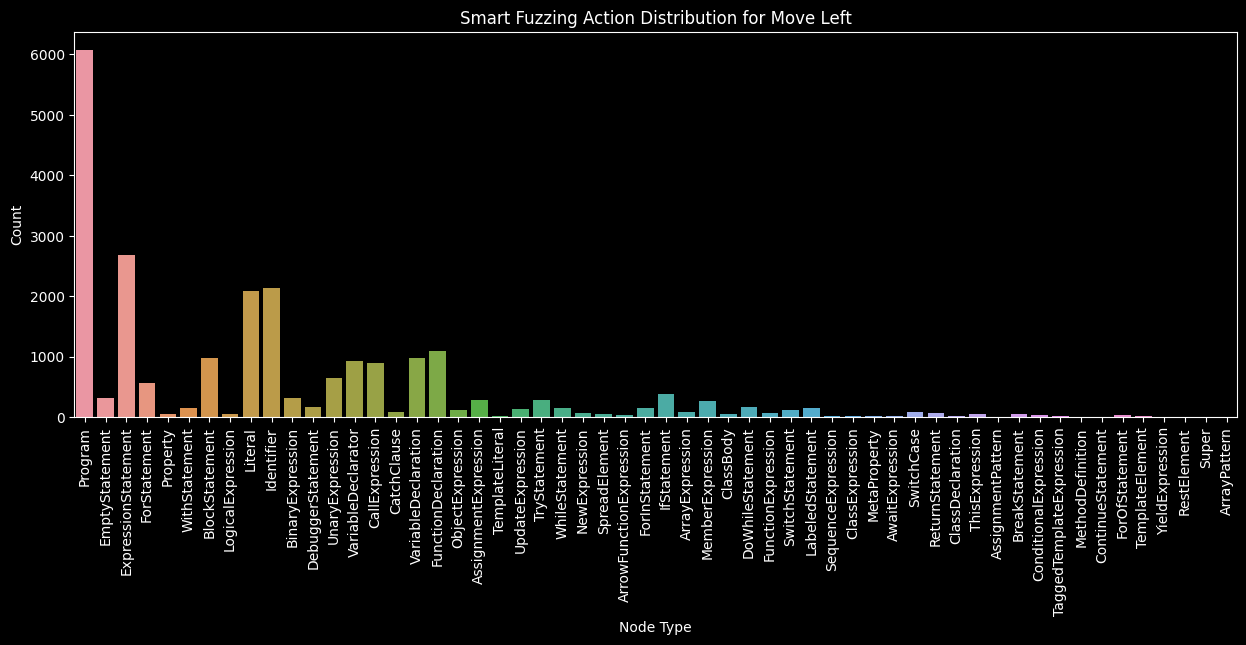

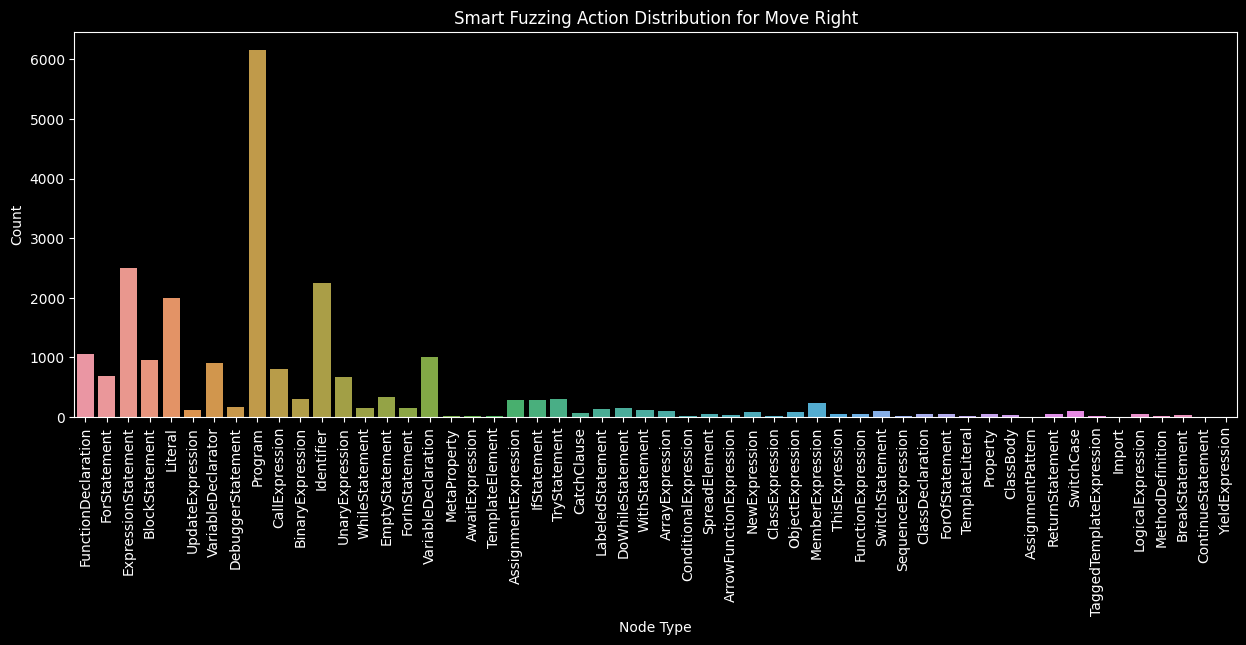

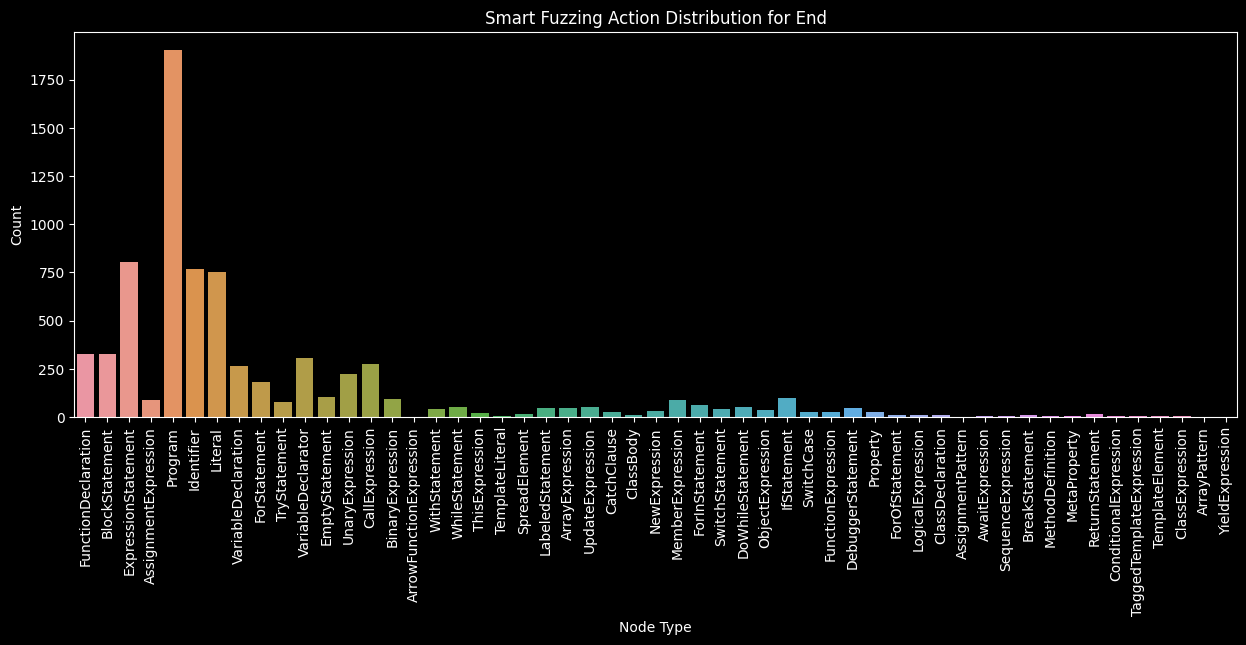

In [268]:
for action in FuzzingAction:
    smart_episode_actions_by_type = [
        x[1] for x in smart_episode_actions if x[0] == action
    ]
    baseline_episode_actions_by_type = [
        x[1] for x in baseline_episode_actions if x[0] == action
    ]

    smart_action_node_type_counts = Counter(smart_episode_actions_by_type)
    baseline_action_node_type_counts = Counter(baseline_episode_actions_by_type)

    smart_action_node_type_counts = pd.DataFrame(
        smart_action_node_type_counts.items(), columns=["node_type", "count"]
    )
    baseline_action_node_type_counts = pd.DataFrame(
        baseline_action_node_type_counts.items(), columns=["node_type", "count"]
    )

    # Plot the distribution of actions by node type using seaborn
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x="node_type", y="count", data=smart_action_node_type_counts)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(xlabel="Node Type", ylabel="Count")
    plt.title(f"Smart Fuzzing Action Distribution for {action}")

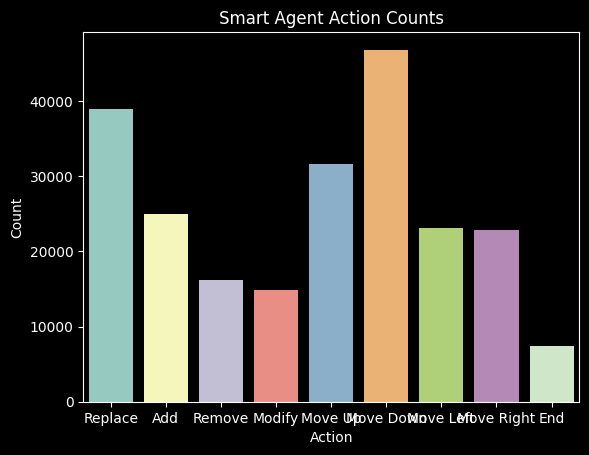

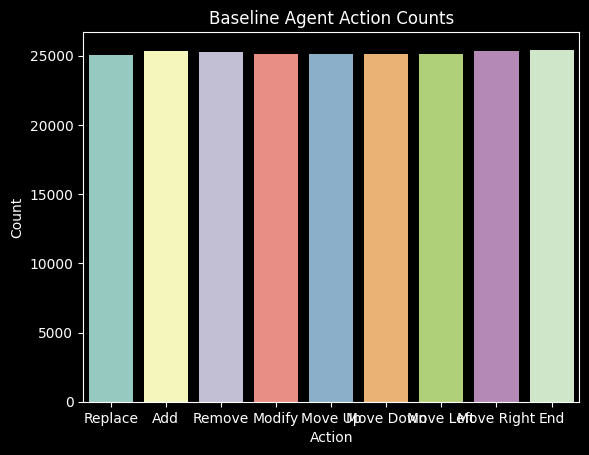

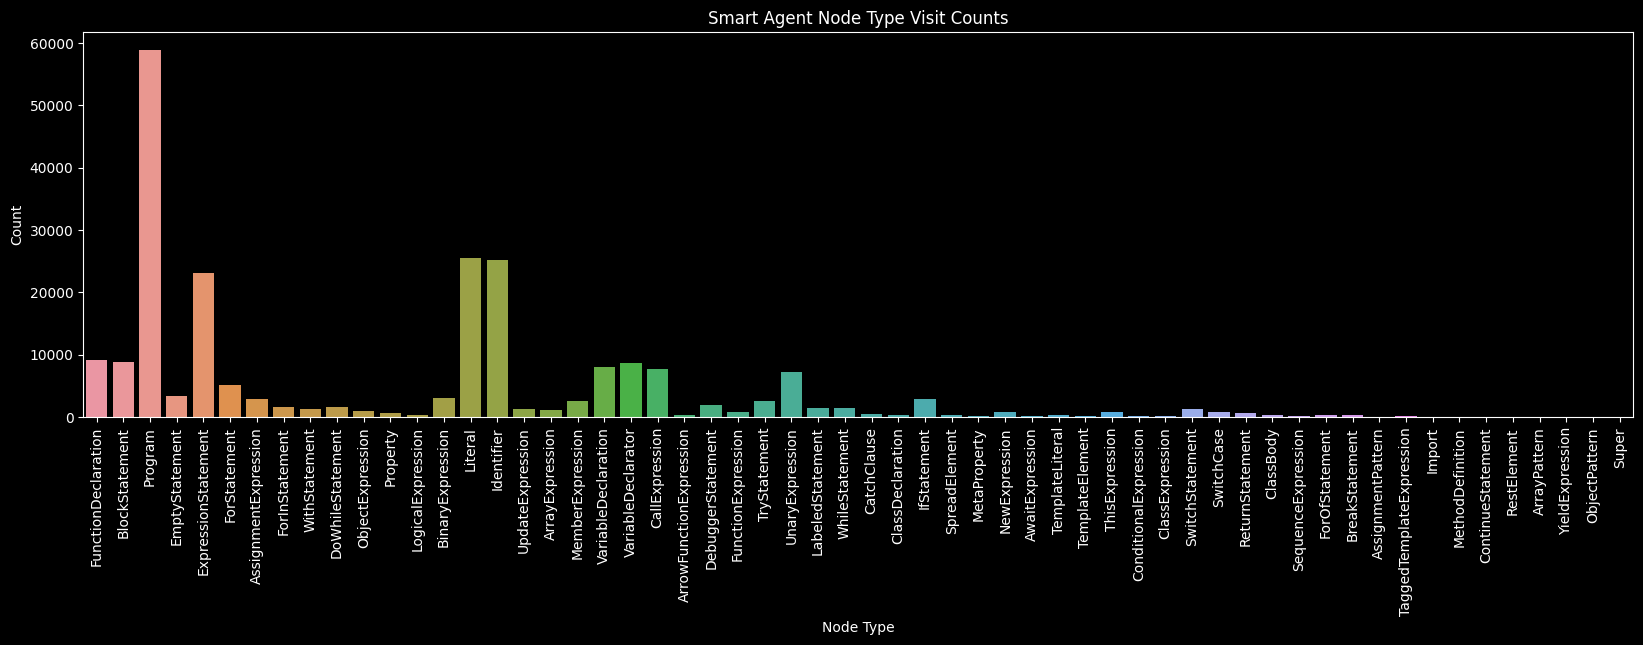

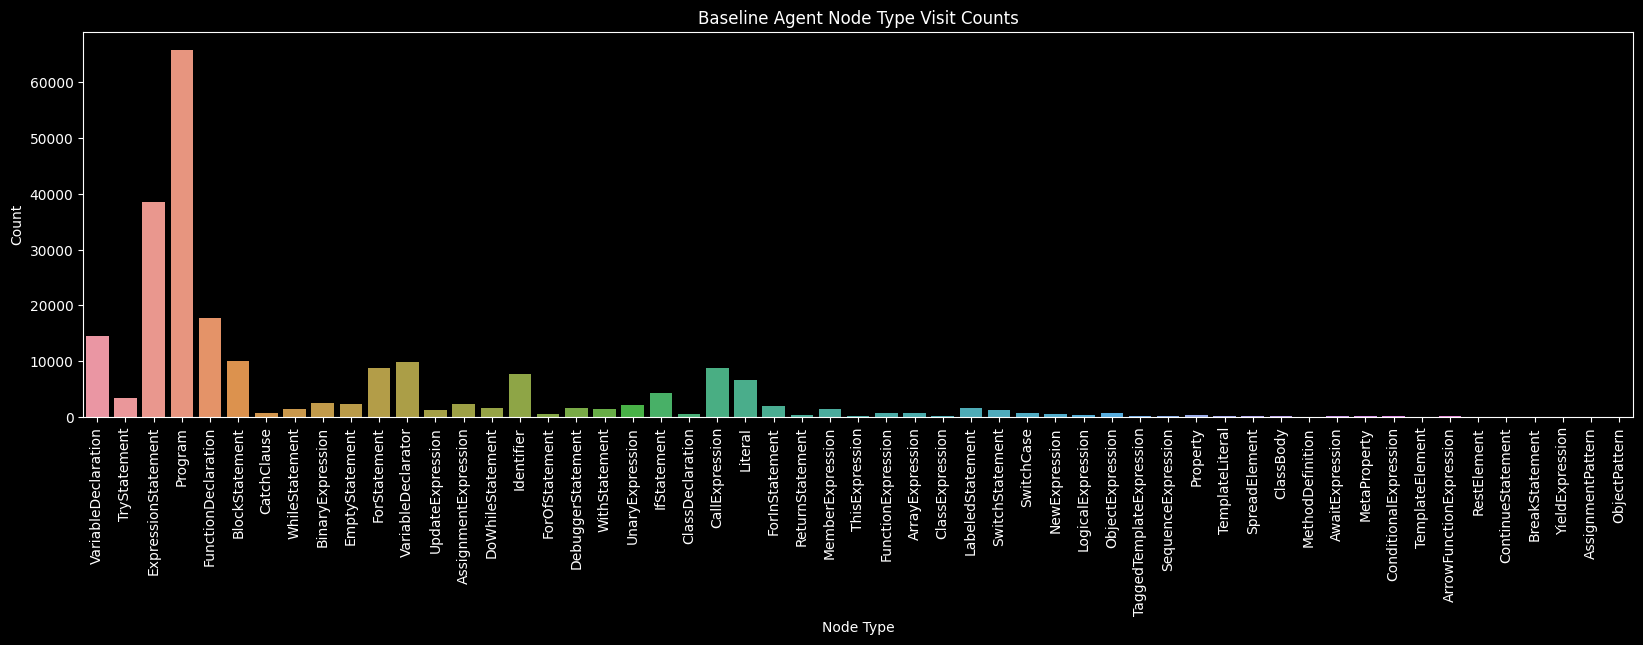

In [269]:
smart_actions, smart_node_types = zip(*smart_episode_actions)
baseline_actions, baseline_node_types = zip(*baseline_episode_actions)

smart_action_counts = Counter(smart_actions)
baseline_action_counts = Counter(baseline_actions)

smart_node_type_counts = Counter(smart_node_types)
baseline_node_type_counts = Counter(baseline_node_types)

smart_action_counts = pd.DataFrame.from_dict(
    smart_action_counts, orient="index"
).sort_index()
baseline_action_counts = pd.DataFrame.from_dict(
    baseline_action_counts, orient="index"
).sort_index()

smart_action_counts["name"] = [str(FuzzingAction(i)) for i in smart_action_counts.index]
baseline_action_counts["name"] = [
    str(FuzzingAction(i)) for i in baseline_action_counts.index
]

smart_node_type_counts = pd.DataFrame.from_dict(smart_node_type_counts, orient="index")
baseline_node_type_counts = pd.DataFrame.from_dict(
    baseline_node_type_counts, orient="index"
)

smart_node_type_counts["name"] = smart_node_type_counts.index
baseline_node_type_counts["name"] = baseline_node_type_counts.index

plt.figure()
ax = sns.barplot(x="name", y=0, data=smart_action_counts)
ax.set(xlabel="Action", ylabel="Count", title="Smart Agent Action Counts")
plt.legend([], [], frameon=False)

plt.figure()
ax = sns.barplot(x="name", y=0, data=baseline_action_counts)
ax.set(xlabel="Action", ylabel="Count", title="Baseline Agent Action Counts")
plt.legend([], [], frameon=False)

plt.figure(figsize=(20, 5))
ax = sns.barplot(x="name", y=0, data=smart_node_type_counts)
ax.set(xlabel="Node Type", ylabel="Count", title="Smart Agent Node Type Visit Counts")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend([], [], frameon=False)


plt.figure(figsize=(20, 5))
ax = sns.barplot(x="name", y=0, data=baseline_node_type_counts)
ax.set(
    xlabel="Node Type", ylabel="Count", title="Baseline Agent Node Type Visit Counts"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend([], [], frameon=False)

In [270]:
with open("../data/js-rl/corpus.pkl", "rb") as f:
    data = pickle.load(f)
  
corpus = data["corpus"]
subtrees = data["subtrees"]
total_coverage = data["total_coverage"]

/home/pranav/.cache/pypoetry/virtualenvs/js-rl-vfj9GiAe-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: Possible set difference at position 2
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/pranav/.cache/pypoetry/virtualenvs/js-rl-vfj9GiAe-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: Possible nested set at position 2
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/pranav/.cache/pypoetry/virtualenvs/js-rl-vfj9GiAe-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: Possible nested set at position 1
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
file_to_node = {
    state.program.origin_file: state for state in corpus
}

program_state_files = smart_interesting_folder.rglob("*.ps")
program_states = {
    file: pickle.load(open(file, "rb"))
    for file in program_state_files
}

In [ ]:
import difflib

for file, state in program_states.items():
    new_program = state.generate_program_code()
    if new_program is None:
        print(f"File {file} failed to generate program code")
        continue
    
    if state.program.origin_file not in file_to_node:
        print(f"File {state.program.origin_file} not found")
    
    old_program = file_to_node[state.program.origin_file].generate_program_code()

    old_program = '\n'.join(['--- Original File ---', old_program])
    new_program = '\n'.join(['+++ Modified File +++', new_program])

    diff_generator = difflib.unified_diff(
        old_program.splitlines(keepends=True),
        new_program.splitlines(keepends=True),
    )

    # Write the diff to the output file
    with open(file.with_suffix(".diff"), 'w') as f:
        f.writelines(diff_generator)

